<a href="https://colab.research.google.com/github/Murarin8877/FinancialBigDataAnalysis-homework/blob/main/Week6_work3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
from sklearn.metrics import mean_squared_error # 計算 mse 誤差
import matplotlib.pyplot as plt # 畫圖套件
import numpy as np # 數值計算套件

In [ ]:
stock_id = "2330.tw"

end = dt.date.today()
start = end - dt.timedelta(days=180)

data = yf.download(stock_id, start=start, end=end).reset_index()

df = data.copy()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-22,740.0,757.0,740.0,742.0,735.861755,46540798
1,2024-04-23,761.0,761.0,752.0,754.0,747.762451,30423647
2,2024-04-24,770.0,785.0,769.0,783.0,776.522583,39457128
3,2024-04-25,770.0,774.0,765.0,766.0,759.663147,28534926
4,2024-04-26,788.0,789.0,782.0,782.0,775.530823,32571247
...,...,...,...,...,...,...,...
115,2024-10-09,1030.0,1035.0,1020.0,1020.0,1020.000000,46975717
116,2024-10-11,1025.0,1050.0,1020.0,1045.0,1045.000000,43058754
117,2024-10-14,1045.0,1055.0,1035.0,1045.0,1045.000000,36858874
118,2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176


#ARIMA（差分整合移動平均自我迴歸模型）

In [ ]:
df_stat = df.copy()

In [ ]:
# 將日期欄位轉為datetime格式
df_stat['Date'] = pd.to_datetime(df_stat['Date'])
# 將日期欄位設為索引
df_stat.set_index('Date', inplace=True)

df_stat

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,740.0,757.0,740.0,742.0,735.861755,46540798
2024-04-23,761.0,761.0,752.0,754.0,747.762451,30423647
2024-04-24,770.0,785.0,769.0,783.0,776.522583,39457128
2024-04-25,770.0,774.0,765.0,766.0,759.663147,28534926
2024-04-26,788.0,789.0,782.0,782.0,775.530823,32571247
...,...,...,...,...,...,...
2024-10-09,1030.0,1035.0,1020.0,1020.0,1020.000000,46975717
2024-10-11,1025.0,1050.0,1020.0,1045.0,1045.000000,43058754
2024-10-14,1045.0,1055.0,1035.0,1045.0,1045.000000,36858874


In [ ]:
# 選擇收盤價作為預測目標
close_prices = df_stat['Close']

# 拆分資料分為訓練集(70%) 和測試集(30%)
train_size = int(len(close_prices) * 0.7)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"訓練集長度: {len(train)}")
print(f"測試集長度: {len(test)}")

訓練集長度: 84
測試集長度: 36


In [ ]:
from statsmodels.tsa.arima.model import ARIMA  # 引入 ARIMA 模型
from math import sqrt  # 引入數學根號
from sklearn.metrics import mean_squared_error
import warnings  # 用來忽略警告訊息（可選）
warnings.filterwarnings("ignore")  # 忽略警告訊息

In [ ]:
# 設定初始範圍，調整的 p, d, q 的範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# 定義函數來評估 ARIMA 模型
def evaluate_arima_model(train, test, arima_order):
    try:
        # 訓練 ARIMA 模型
        model = ARIMA(train, order=arima_order)
        arima_result = model.fit()

        # 預測未來
        yhat = arima_result.forecast(steps=len(test))

        # 計算 RMSE
        rmse = np.sqrt(mean_squared_error(test, yhat))
        return rmse
    except Exception as e:
        # 當模型無法收斂或其他錯誤時，返回無效的結果
        print(f"Error for ARIMA{arima_order}: {e}")
        return np.inf

# 進行網格搜索，找出最佳的 (p, d, q)
def evaluate_models(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_model = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                rmse = evaluate_arima_model(train, test, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    best_model_tmp = ARIMA(train, order=order)
                    best_model = best_model_tmp.fit()
                    print(f'ARIMA{order} RMSE={rmse:.3f}')
    print(f'最佳 ARIMA 模型: ARIMA{best_cfg}，最小 RMSE: {best_score:.3f}')
    return best_model

In [ ]:
best_model = evaluate_models(train, test, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=75.770
ARIMA(0, 1, 0) RMSE=45.506
ARIMA(0, 1, 1) RMSE=45.274
ARIMA(0, 2, 3) RMSE=42.815
ARIMA(2, 2, 3) RMSE=41.015
ARIMA(2, 2, 4) RMSE=40.631
ARIMA(3, 2, 4) RMSE=40.094
ARIMA(4, 2, 5) RMSE=39.522
ARIMA(5, 2, 5) RMSE=37.018
最佳 ARIMA 模型: ARIMA(5, 2, 5)，最小 RMSE: 37.018


In [ ]:
# 預測未來30天
yhat = best_model.forecast(steps=len(test))

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, yhat))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")


RMSE: 37.01825263571074


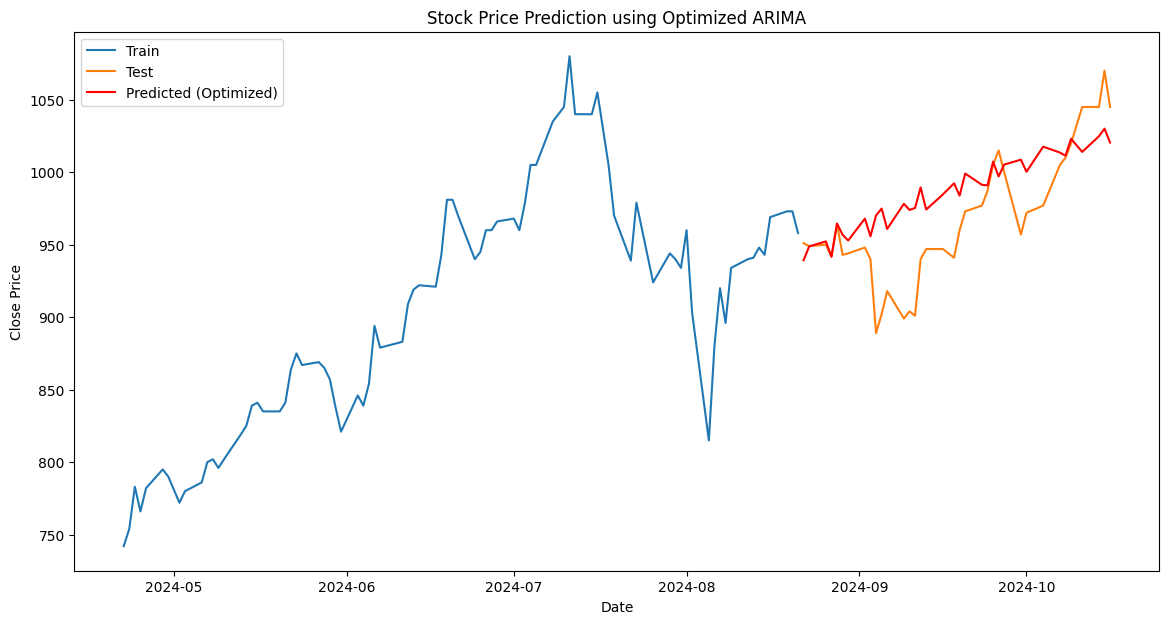

In [ ]:
# 繪製折線圖
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, yhat, color='red', label='Predicted (Optimized)')
plt.title('Stock Price Prediction using Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#量化交易
黃金交叉（Golden Cross）：當短期移動平均線（短期 MA）從下方突破長期移動平均線（長期 MA），這被認為是一個買入信號。這代表著短期內價格上升的趨勢開始超過長期趨勢，市場可能進入一個上漲階段。

死亡交叉（Death Cross）：當短期 MA從上方跌破長期 MA，這被認為是一個賣出信號。這代表著短期內的價格趨勢弱於長期趨勢，市場可能進入下跌階段。

In [ ]:
# 取得股票資訊，輸入股票代號
stock_id = "2330.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2023, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,306.430176,31754120
2020-01-03,344.0,345.0,335.5,339.5,306.882141,41811268
2020-01-06,333.0,334.5,332.0,332.0,300.102753,45343057
2020-01-07,332.5,333.0,326.5,329.5,297.842926,50879181
2020-01-08,325.0,333.0,325.0,329.5,297.842926,37567748
...,...,...,...,...,...,...
2022-12-26,454.0,457.0,453.5,456.5,441.325226,8793306
2022-12-27,458.0,462.5,457.0,457.0,441.808624,10264001
2022-12-28,451.0,452.0,446.0,451.0,436.008087,32578949


In [100]:
df2 = stock_data.copy()
#df2 = df.copy()
#df2.set_index('Date', inplace=True)

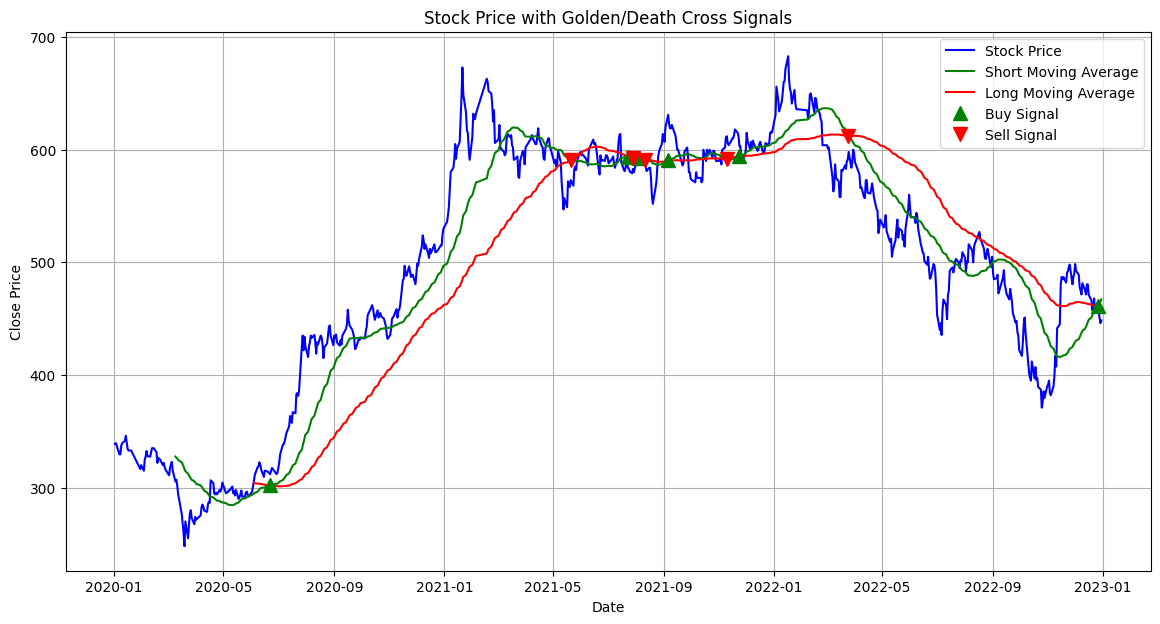

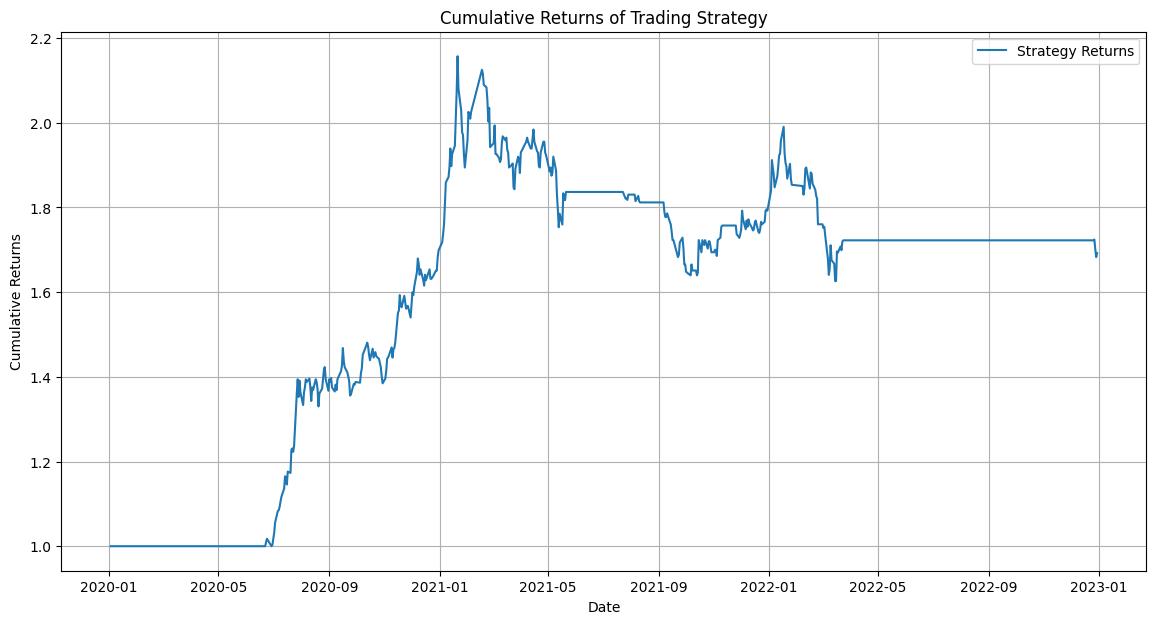

In [102]:
# prompt: 量化交易
# 黃金交叉（Golden Cross）：當短期移動平均線（短期 MA）從下方突破長期移動平均線（長期 MA），這被認為是一個買入信號。這代表著短期內價格上升的趨勢開始超過長期趨勢，市場可能進入一個上漲階段。
# 死亡交叉（Death Cross）：當短期 MA從上方跌破長期 MA，這被認為是一個賣出信號。這代表著短期內的價格趨勢弱於長期趨勢，市場可能進入下跌階段


# 計算移動平均線 (MA)
short_window = 40  # 短期 MA 的窗口大小
long_window = 100  # 長期 MA 的窗口大小
df2['Short_MA'] = df2['Close'].rolling(window=short_window).mean()
df2['Long_MA'] = df2['Close'].rolling(window=long_window).mean()

# 找出黃金交叉和死亡交叉
df2['Signal'] = 0
df2.iloc[short_window:, df2.columns.get_loc('Signal')] = (
    df2['Short_MA'].iloc[short_window:] > df2['Long_MA'].iloc[short_window:]
).astype('int64')
df2['Position'] = df2['Signal'].diff()

# 繪製圖表，顯示價格、MA 和交易訊號
plt.figure(figsize=(14, 7))
plt.plot(df2.index,df2['Close'], label='Stock Price', color='blue')
plt.plot(df2.index,df2['Short_MA'], label='Short Moving Average', color='green')
plt.plot(df2.index,df2['Long_MA'], label='Long Moving Average', color='red')

plt.plot(df2[df2['Position'] == 1].index, df2['Short_MA'][df2['Position'] == 1], '^', markersize=10, lw=0, color='g', label='Buy Signal')
plt.plot(df2[df2['Position'] == -1].index, df2['Short_MA'][df2['Position'] == -1], 'v', markersize=10, lw=0, color='r', label='Sell Signal')


plt.title('Stock Price with Golden/Death Cross Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 計算交易策略的回報率 (簡易版本)
df2['Returns'] = df2['Close'].pct_change()
df2['Strategy_Returns'] = df2['Returns'] * df2['Signal'].shift(1)
cumulative_returns = (1 + df2['Strategy_Returns']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.title('Cumulative Returns of Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df2.iloc[:50]

,Open,High,Low,Close,Adj Close,Volume,Short_MA,Long_MA,Signal,Position,Returns,Strategy_Returns
Date,,,,,,,,,,,,
2024-04-22,740.0,757.0,740.0,742.0,735.861755,46540798,NaN,NaN,0,NaN,NaN,NaN
2024-04-23,761.0,761.0,752.0,754.0,747.762451,30423647,NaN,NaN,0,0.0,0.016173,0.000000
2024-04-24,770.0,785.0,769.0,783.0,776.522583,39457128,NaN,NaN,0,0.0,0.038462,0.000000
2024-04-25,770.0,774.0,765.0,766.0,759.663147,28534926,NaN,NaN,0,0.0,-0.021711,-0.000000
2024-04-26,788.0,789.0,782.0,782.0,775.530823,32571247,765.4,NaN,0,0.0,0.020888,0.000000
2024-04-29,790.0,795.0,787.0,795.0,788.423279,26765837,776.0,NaN,0,0.0,0.016624,0.000000
2024-04-30,797.0,802.0,790.0,790.0,783.464661,39051972,783.2,NaN,0,0.0,-0.006289,-0.000000
2024-05-02,789.0,789.0,772.0,772.0,765.613586,40527228,781.0,NaN,0,0.0,-0.022785,-0.000000
2024-05-03,788.0,788.0,773.0,780.0,773.547363,29901556,783.8,NaN,0,0.0,0.010363,0.000000


#code範例(以下忽略)

In [ ]:
# 設計均值回歸策略
def mean_reversion_strategy(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

    # 初始訊號：0 代表不操作
    data['Signal'] = 0

    # 短均線高於長均線，發出買入信號
    # .astype('int64') 將 True 變成1，False 變成0
    #short_window: row,data.columns.get_loc('Signal')欄
    #計算Signal欄位，並找出SMA>LMA的列，並用0 1 代。
    data.iloc[short_window:, data.columns.get_loc('Signal')] = (
        data['Short_MA'].iloc[short_window:] > data['Long_MA'].iloc[short_window:]
    ).astype('int64')
    # .diff() 使用差分計算買入或賣出(True 代表 1， False代表 0)
    # 當信號從 False（0）變為 True（1）時，1 - 0 = 1 差分為 1，表示買入信號。
    # 當信號從 True（1）變為 False（0）時，0 - 1 = -1 差分為 -1，表示賣出信號。
    data['Position'] = data['Signal'].diff()
    #print(data['Signal'])
    #print(data['Position'])
    return data

In [ ]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 填空值為 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 買入訊號(1)或賣出訊號(-1) * 股數，-100代表賣100股，100代表買100股
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

   # 買入或賣出股票數 * 收盤價，計算每個時間點持有的股票價值
    portfolio = positions.multiply(data['Close'], axis=0)

    # 計算每個時間點股票持倉的變化量（買入或賣出股票的數量）
    pos_diff = positions.diff()


    # 計算持有的股票價值（資產組合中持有的部分）
    # 將持倉數量與收盤價相乘，並對每個時間點的所有持倉進行求和，得到當天的總持倉價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)

    # 計算現金部分
    # 初始資金減去所有交易的累積花費/收益，並根據股票價格乘以持倉變動來計算現金變化
    # cumsum() 用來累積計算現金變化，保持隨著時間推移的總現金變化
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    # 總資產 = 現金部分 + 持有的股票價值部分
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')
    plt.plot(data['Short_MA'], label='Short Moving Average', color='green')
    plt.plot(data['Long_MA'], label='Long Moving Average', color='red')

    # 標註買賣點
    plt.plot(data[data['Position'] == 1].index,
             data['Short_MA'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Short_MA'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Mean Reversion Strategy Backtest')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

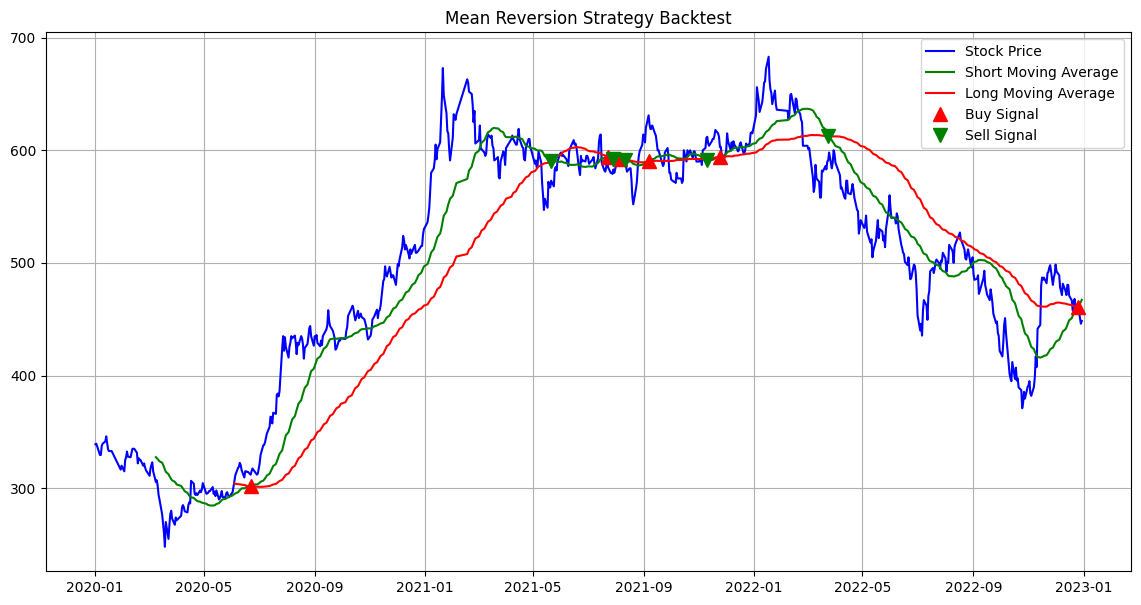

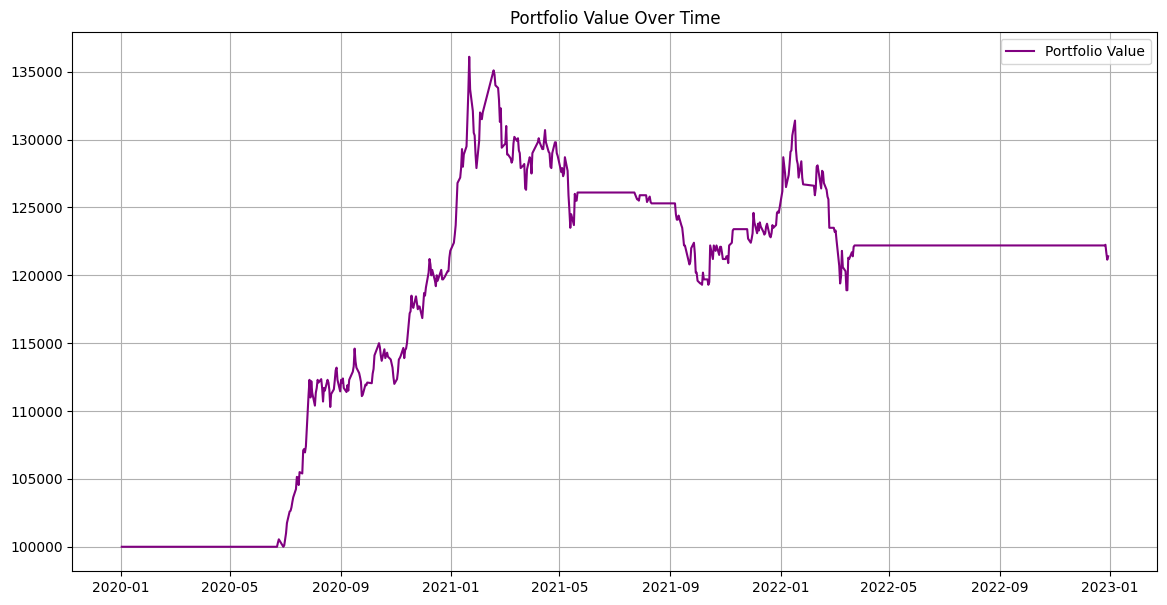

In [ ]:
 # 設定策略參數：短期移動平均線窗口與長期移動平均線窗口
short_window = 40
long_window = 100

# 應用均值回歸策略
stock_data = mean_reversion_strategy(stock_data, short_window, long_window)
# 回測並可視化結果
backtest_and_plot(stock_data)

In [ ]:
#解釋
stock_data.iloc[406:452]
#signal0變成1表示(2021-09-06:SMA>LMA)，且由於使用差分計算，會得出Position= 1(2021-09-06的Signal) - 0(2021-09-03的Signal)此時為買入訊號。
#如果要賣出要直到2021-11-10 SMA<LMA得到Signal = 0，也得出Position= 0(2021-11-10的Signal) - 1(2021-11-9的Signal)此時才賣出。

,Open,High,Low,Close,Adj Close,Volume,Short_MA,Long_MA,Signal,Position
Date,,,,,,,,,,
2021-09-03,610.0,620.0,610.0,620.0,581.107178,51562454,589.500,589.50,0,0.0
2021-09-06,623.0,638.0,621.0,631.0,591.417114,55589014,590.450,589.62,1,1.0
2021-09-07,634.0,634.0,623.0,623.0,583.918884,26526056,590.850,589.75,1,0.0
2021-09-08,622.0,627.0,612.0,619.0,580.169983,37817737,591.000,589.91,1,0.0
2021-09-09,612.0,620.0,610.0,619.0,580.169983,18735512,591.125,590.08,1,0.0
2021-09-10,615.0,623.0,614.0,622.0,582.981567,16304725,591.950,590.38,1,0.0
2021-09-13,619.0,620.0,613.0,615.0,576.420837,15198774,592.775,590.62,1,0.0
2021-09-14,618.0,618.0,612.0,613.0,574.546326,14441901,593.575,590.73,1,0.0
2021-09-15,610.0,613.0,607.0,607.0,568.922607,23433501,594.125,590.70,1,0.0
